# Timing Syncronization

In [1]:
%matplotlib widget
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import rcosdesign
import textwrap

mpl.rcParams.update({"axes.grid" : True})

## Motivation

### Some Theory
For single carrier modulations, the output of the matched filtered downsampled at *right* time is the *optimal* estimate of the transmitted symbol. Formally, the transmitted signal is 
$$
s(t) = \sum_{i=0}^{N} a_i p(t - i T_s) 
$$
for some $a_i$ from the constellation $C$ for $N$ input symbols, symbol time $T_s$, and pulse shape $p(t)$. The received signal is often modeled as
$$
r(t) = G_a \sum_{i=0}^{N} a_i p(t - i T_s - \tau) + w(t)
$$
for some additivie white gaussian noise $w(t)$ and cummulative gain $G_a$. 

The *optimal estimate* of the $i$-th symbol, $a_i$, is given by
$$
\hat x_i = \int_{iT_s}^{(i+1)T_s} r(t) p(t) dt,
$$
where $iT_s$ and $(i+1)T_s$ correspond the beginning and ending times of the $i$-th symbol period. Thus, the matched filter performs the correlation operation and the down-sample extracts the value corresponding to the correct time period. It is clear from this equation that if the bounds of the integral (i.e. the down-sample offset) don't correspond to the correct matched filter output, the estimate of the symbol will be non-optimal.

For more on this topic, see Chapter 8 of *Digital Communciations: A Discrete-Time Approach*.

### Some Practicality
Why is it difficult to align two radios in time? In essence, their local oscillators for their internal clocks are to blame. They won't be time syncronized (e.g. both radios weren't turned on at exactly the same moment) and they will both experience clock frequency drift and offset due to imperfections in their constructions.

### Activity: Creating a Signal in Discrete Time
Look at the python code in the following section. Read it and attempt to understand what is going on. Comment and uncomment relevant sections to understand how the signal is being constructed.

#### Questions
- What do all the different paths on the eye diagram represent?
- What do you notice about the rectangular and Manchester pulse shapes v.s. the SRRC?
- How does altering the constellation effect $s(t)$?
- What does changing the samples per symbol (SPS) translate too? (remember to reset this to 12 when you move on)
- What does altering $\alpha$ effect for the SRRC?
- Regarding the equation for $\hat x_i$, why do you think this equation would be the optimal estimate for $a_i$.

In [2]:
constellation = [-1, 1]         # Binary PAM Constellation -> Only change to a real valued constellation
# constellation = [-3, -1, 1, 3]  # 4-ary PAM Constellation
alpha = 0.5                     # Keep this between 0 and 1
SPS = 12                        # Keep this an even number for indexing purposes
ps = 'SRRC'
# ps = 'RECT'
# ps = 'MAN'

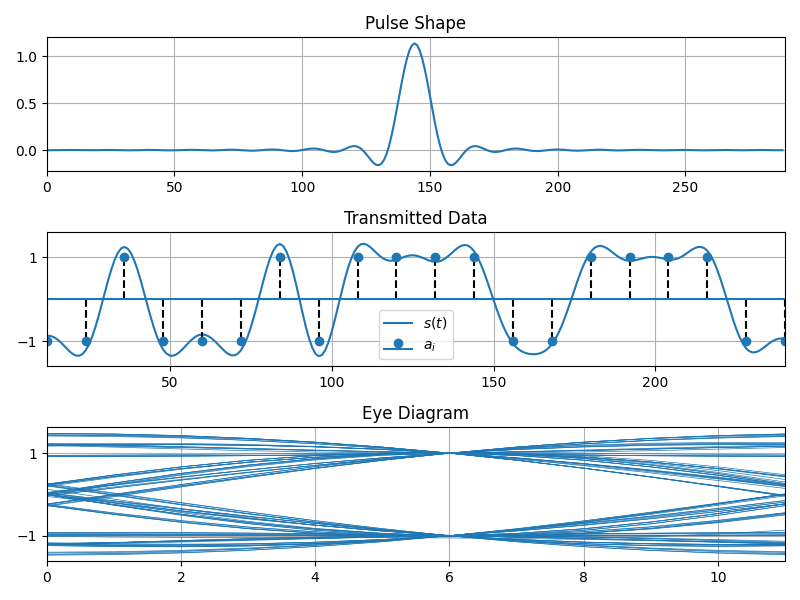

In [3]:
# Generate Figures and Signal
if   ps == 'SRRC': pulseShape = rcosdesign.srrcDesign(SPS=SPS, beta=alpha, span=12)*SPS
elif ps == 'RECT': pulseShape = np.ones(SPS)
elif ps ==  'MAN': pulseShape = np.concatenate([np.ones(SPS//2), -1*np.ones(SPS//2)])
data = np.random.choice(constellation, size=100) # BPSK
dataUpSampled = np.zeros(100*SPS)
dataUpSampled[0::SPS] = data
txSignal = np.convolve(dataUpSampled,    pulseShape , "Same")
mfOutput = np.convolve(txSignal, np.flip(pulseShape), "Same") / np.sum(pulseShape)

plt.figure('Signal Construction', figsize=(8, 6))
plt.clf()
plt.subplot(3, 1, 1)
plt.title('Pulse Shape')
plt.plot(pulseShape)
plt.xlim([0, len(pulseShape)])

plt.subplot(3, 1, 2)
plt.title('Transmitted Data')
plt.plot(txSignal, label='$s(t)$')
plt.stem(np.arange(0, 100*SPS, SPS), data, markerfmt='C0o', linefmt='k--', basefmt='C0-', label='$a_i$')
plt.xlim([SPS, 20*SPS])
plt.yticks(constellation)
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Eye Diagram')
for row in np.reshape(mfOutput[SPS//2:-(SPS//2)], (-1, SPS)):
    plt.plot(row, color='C0', linewidth=0.5)
plt.yticks(constellation)
plt.xlim([0, SPS-1])

plt.tight_layout()
plt.show()

### Activity: Experiement with down-sampling at the wrong time
- Alter the down-sampling offset and observe what happens on the constellation diagram when the sample offset is adjusted.
- Alter $\alpha$ in the previous section and observe the effect that it has on the constellation diagram when using the correct down-sampling offset.
- Alter the constellation in the previous section and observe the effect on the eye and constellation diagrams. 
    - What do you notice? 
    - What happens if $\alpha$ is adjusted with the new constellation?

#### Questions
- According to the Eye Diagram, what is the correct down-sampling offset?
- Why does down-sampling at the correct offset time not produce values at exactly 1 or -1?


In [7]:
samplingOffset = 3 # Keep within the range (0 to SPS)

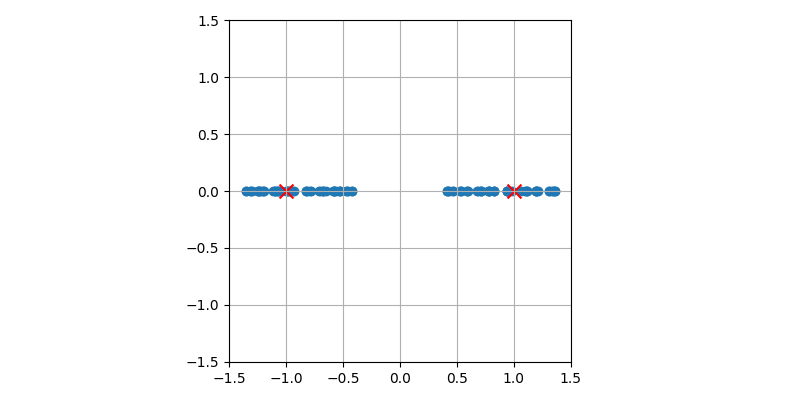

In [8]:
# Constellation Diagram
dataEstimate = mfOutput[(SPS//2)+samplingOffset:-SPS//2:SPS]

plt.figure('Constellation Diagram', figsize=(8, 4))
plt.clf()
plt.subplot(1, 1, 1, aspect='equal')
plt.scatter(np.real(dataEstimate), np.imag(dataEstimate), label='Data Estimates')
plt.scatter(np.real(constellation), np.imag(constellation), marker='x', c='red', s=100, label='Constellation Points')
plt.ylim([-0.5, 0.5])
plt.xlim([min(constellation)-0.5, max(constellation)+0.5])
plt.ylim([min(constellation)-0.5, max(constellation)+0.5])
plt.tight_layout()
plt.show()

## Timing Error Detectors (TEDs)

Now that we've explored *why* timing syncronization is important, lets consider how to fix the problem. The first element of a timing syncronizer for single-carrier waveforms is the **Timing Error Detector** or TED. The most common approach to determine the timing error is to look at the slope of the eye diagram. It should be clear from the first set of graphs that at the right sampling moment, the slope of the matched filter output should be $0$. Consider this figure stolen from Dr. Rice's textbook: 

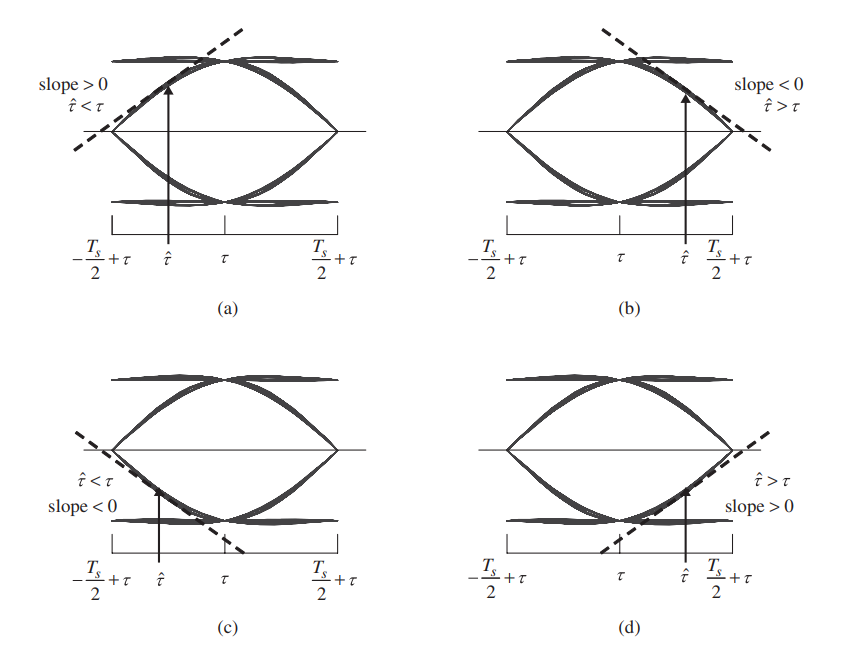

Consider what the slope is for the following cases: 
1. Early timing and positive symbol
2. Early timing and negative symbol
3. Late timing and positive symbol
4. Late timing and negative symbol

Stop here and consider: **How might you design an error function that indicated which direction to move the timing for BPSK?**

If you actually thought about it, you might consider a function like
$$
e(t) = \hat a_k \dot {\hat {x}}_k
$$
where the dot refers to the derivative of the matched filter estimate. Here the sign of the symbol will align the slopes of the negative symbols to match direction indicated by the slopes of the positive symbols. You might notice a few problems with this setup right away with thoughs such as:
- How do I even take the derivative of a single sample?
- There is no way that is even defined right?
- Stop talking crazy, I can't compute that error function

and you'd be right. We need to be even smarter to approximate this fictitious error function.

### Activity: Implementing a TED for a PLL

Study the code below that implements a Timing PLL below. It is not necessary to understand how Phase Lock Loops work, just look through it to understand the general idea of what is going on. The data recorded is from two ADALM-PLUTO SDRs. The data was modulated with QPSK and has an actual timing offset. The plots below should help you debug if you need help. Additionally, there is a text message hidden with the data. You will have succeeded if you get a readable message out. The timing error function for QPSK is
$$
\Im\{ \hat{a}_k^* \hat{x}_k \}
$$
where $\Im\{ \cdot \}$ means to take the imaginary part of the complex number.

Be sure to record the message for you lab report.

### Questions
- $B_n$ is referred to as the noise bandwidth. What happens to the graphs below when it is increased and decreased?
- $\zeta$ is called the dampening factor. What happens to the graphs below when it is increased and decreased?
- What happens to the text message if the error is set to $0$ as it is originally? Describe why this is the case.
- Who gave the quote?
- Describe how what you learned today will contribute to the design of your protocol and receiver?

In [ ]:
# Load in a real signal
const = np.array([ -1-1j, -1+1j, +1-1j, +1+1j ])    # QPSK Constellation
receivedSignal = np.loadtxt('realdata.txt', dtype=complex)

# PLL
# Loop Gains
zeta = 0.7071
Bn = 0.05
K0 = 1
KP = np.sqrt(2)
K1 = 4*zeta*Bn/(zeta+(1/(4*zeta)))/(KP*K0)
K2 = (4*zeta)/((zeta+1/(zeta*4))**2)*(Bn**2)/(KP*K0)
# State Variable Vectors
Ahat    = np.zeros(receivedSignal.shape, dtype=complex)
ERROR   = [0]
A_TILDE = []
PHI     = [0]
V       = [0]
# Run PLL
for k in range(0, len(receivedSignal)):
    # Algebraic Relationships
    phi     = PHI[-1] + V[-1]
    x_hat   = receivedSignal[k] * np.exp(-1j*phi)
    Ahat[k] = np.sign(np.real(x_hat)) + 1j*np.sign(np.imag(x_hat))
    e       = 0 # FIXME - Implement this equation!!!!!!
    v       = V[-1] + (K1 + K2)*e - K1 * ERROR[-1]
    
    # Update States
    A_TILDE.append(x_hat)
    ERROR.append(e)
    PHI.append(phi)
    V.append(v)
    

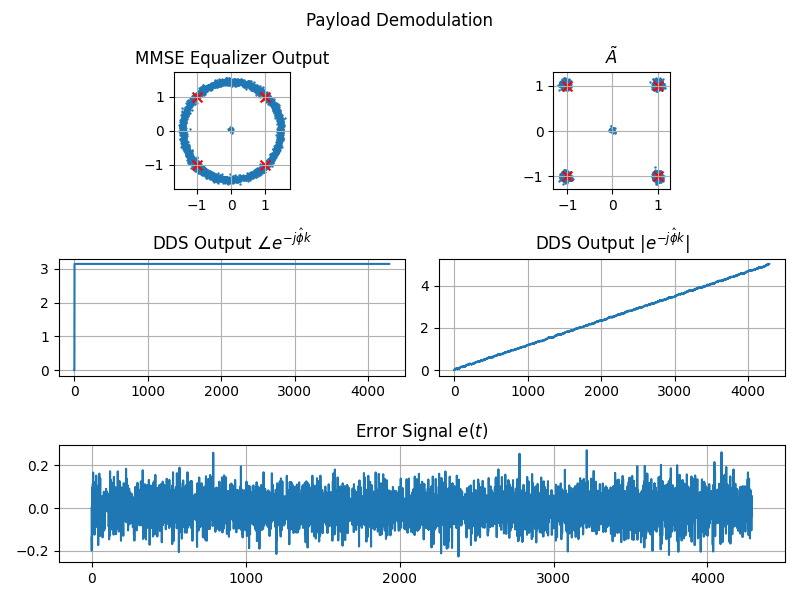

In [16]:
plt.figure(5, figsize=(8, 6))
plt.clf()
gs = mpl.gridspec.GridSpec(3, 2, figure=plt.gcf())
plt.suptitle('Payload Demodulation')
plt.subplot(gs[0, 0], aspect='equal')
plt.title('MMSE Equalizer Output')
plt.scatter(np.real(receivedSignal), np.imag(receivedSignal), s=0.5)
plt.scatter(np.real(const), np.imag(const), s=50, color='red', marker='x')
plt.subplot(gs[2, 0:4])
plt.title(r'Error Signal $e(t)$')
plt.plot(ERROR)
plt.subplot(gs[0, 1], aspect='equal')
plt.title(r'$\tilde{A}$')
plt.scatter(np.real(A_TILDE), np.imag(A_TILDE), s=0.5)
plt.scatter(np.real(const), np.imag(const), s=50, color='red', marker='x')
plt.subplot(gs[1, 0])
plt.title(r'DDS Output $\angle e^{-j\hat{\phi}k}$')
plt.plot(np.angle(PHI))
plt.subplot(gs[1, 1])
plt.title(r'DDS Output $| e^{-j\hat{\phi}k} |$')
plt.plot(np.abs(PHI))
plt.tight_layout()
plt.show()

In [17]:
pre_length = 126
Mary = np.array([ np.where(const == i)[0] for i in Ahat[pre_length+1:] ]).reshape((-1,))
bin_str = ''.join([ '{0:02b}'.format(m) for m in Mary])
mary = [ int(bin_str[i:i+7], 2) for i in range(0, len(bin_str), 7)]
message = ''.join([ chr(m) for m in mary[:1192-4]])
print(textwrap.fill(message, 150))

I ask, what can ignite spiritual momentum? We have seen examples of both positive and negative momentum. We know followers of Jesus Christ who became
converted and grew in their faith. But we also know of once-committed believers who fell away. Momentum can swing either way.  We have never needed
positive spiritual momentum more than we do now, to counteract the speed with which evil and the darker signs of the times are intensifying. Positive
spiritual momentum will keep us moving forward amid the fear and uncertainty created by pandemics, tsunamis, volcanic eruptions, and armed
hostilities. Spiritual momentum can help us withstand the relentless, wicked attacks of the adversary and thwart his efforts to erode our personal
spiritual foundation.  Many actions can ignite positive spiritual momentum. Obedience, love, humility, service, and gratitude are but a few.  Today I
would like to suggest five specific actions we can take to help us maintain positive spiritual momentum.  (1) Get on